## Actividades 5 y 7
----

Primero voy a importar una librerias y crear las variables necesarias para empezar el TP2.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris  
from sklearn import neighbors
import seaborn as sns
from sklearn.metrics import accuracy_score
#para que matplotlib tengo los gráficos de seaborn
from sklearn.model_selection import GridSearchCV 
sns.set
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import scikitplot as skplt
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import pandas as pd
import seaborn as sn
import xgboost as xgb
import numpy as np
import torch
from torch import nn
import collections
from torchvision.datasets.utils import download_and_extract_archive
import os
import matplotlib
%matplotlib inline
import sympy as sp
from funciones_utiles import polynomial_features
from torch.optim import SGD
import matplotlib.pyplot as plt
from torch.utils import data
import warnings
from funciones_utiles import create_sinusoidal_data as create_data
warnings.simplefilter('ignore')

np.random.seed(12345)


## 5. A partir de la versión con mini-batches, modificar el bucle de entrenamiento para que, sin modificar la iteración sobre el DataLoader, implemente descenso de gradiente estándar (*vanilla*) (actualización utilizando el gradiente sobre la función de costo acumulada, tras recorrer todo el dataset).
---
<br>
A continuación defino el modelo básico, donde voy a comentar en el código las lineas que modifico.

In [2]:
x_train, y_train, x_val, y_val = create_data()
P = 3

x_train_vec = polynomial_features(x_train, P)
y_train_vec = y_train.reshape(-1, 1) # aumentamos nuestro tensor de 1D a 2D pues así lo usará nuestro modelo

x_test_vec = polynomial_features(x_val, P)
y_test_vec = y_val.reshape(-1, 1)

print(x_train_vec.shape, x_test_vec.shape)

(10, 3) (50, 3)


In [3]:
class FeedforwardNet(nn.Module):
    def __init__(self, num_features, num_hidden, output):
        super(FeedforwardNet, self).__init__()
        # completa con tu código aquí
        self.fc1 = torch.nn.Linear(num_features, num_hidden, bias=True)
        self.ReLU = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(num_hidden, output, bias=True)
        
    def forward(self, x):
        # completa con tu código aquí
        out = self.fc1(x)
        out = self.ReLU(out)
        out = self.fc2(out)
        return out

In [4]:
model = FeedforwardNet(num_features=P, num_hidden = 2, output=1)

# si tenemos GPU, llevamos el modelo ahí
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')    
    
model.to(device)

model.train()  # modelo nuevamente activado para entrenamiento

LEARNING_RATE = 0.01

WEIGHT_DECAY = 0.01  # L2 regularization coef.

criterion = nn.MSELoss(reduction='sum')

optimizer = SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


from torch.utils import data

BATCH_SIZE = 5

### ** En este siguiente bloque se puede visualizar la modificación **
<br>
ver comentarios en el código

In [5]:
# ENTRENAMIENTO
EPOCHS = 10000
x_train_tensor = torch.from_numpy(np.float32(x_train_vec)).to(device)
y_train_tensor = torch.from_numpy(np.float32(y_train_vec)).to(device)
n_train = len(x_train_tensor)

x_test_tensor = torch.from_numpy(np.float32(x_test_vec)).to(device)
y_test_tensor = torch.from_numpy(np.float32(y_test_vec)).to(device)


train_data = data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,)

val_data = data.TensorDataset(x_test_tensor, y_test_tensor)
val_loader = data.DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0,)

print(len(train_data), len(train_loader))

train_loss, val_loss = [], []

for epoch in range(EPOCHS):
       
    train_loss_acc = 0.  
    #####################
    # Aquí es donde hacemos los gradientes en cero, en lugar de adentro del bucle del "train_loader"
    # de esta forma, cuando ingrese al bucle, se actualizen los gradientes una vez que recorre
    # todo el bucle del train_loader, osea todas las muestras, como si fuera "vanilla"
    optimizer.zero_grad() 
    #####################
    for x, y in train_loader:
        x.to(device, non_blocking=True)
        y.to(device, non_blocking=True)
       
        y_pred = model(x)
        loss = criterion(y_pred, y) / BATCH_SIZE
        loss.backward()
        
        
        train_loss_acc += loss.detach().item()
        
    train_loss.append(train_loss_acc / len(train_data))    


    #####################
    # Aquí actualizamos los parámetros del modelo, una vez que recorrio todo el bucle del train loader
    # de esta forma conseguimos implementar el descenso de gradiente estándar (vanilla)
    optimizer.step()  # línea de código modificada, la baje con respecto al código original
    #####################


    with torch.no_grad():
        val_loss_acc = 0.
        for x, y in val_loader:        
            x.to(device, non_blocking=True)
            y.to(device, non_blocking=True)        
            
            y_pred = model(x)      
            loss = criterion(y_pred, y)
            
            val_loss_acc += loss.item()    
        val_loss.append(val_loss_acc / len(val_data))
        
    if epoch % (EPOCHS//10) == 0:
        print("epoch = {:02d}, train_loss = {:.3e}, val_loss = {:.3e}".format(epoch, train_loss_acc, val_loss_acc))

10 2
epoch = 00, train_loss = 1.414e+00, val_loss = 2.920e+01
epoch = 1000, train_loss = 1.190e+00, val_loss = 2.451e+01
epoch = 2000, train_loss = 1.190e+00, val_loss = 2.451e+01
epoch = 3000, train_loss = 1.190e+00, val_loss = 2.451e+01
epoch = 4000, train_loss = 1.190e+00, val_loss = 2.451e+01
epoch = 5000, train_loss = 1.190e+00, val_loss = 2.451e+01
epoch = 6000, train_loss = 1.190e+00, val_loss = 2.451e+01
epoch = 7000, train_loss = 1.190e+00, val_loss = 2.451e+01
epoch = 8000, train_loss = 1.190e+00, val_loss = 2.451e+01
epoch = 9000, train_loss = 1.190e+00, val_loss = 2.451e+01


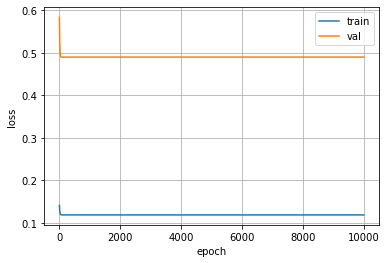

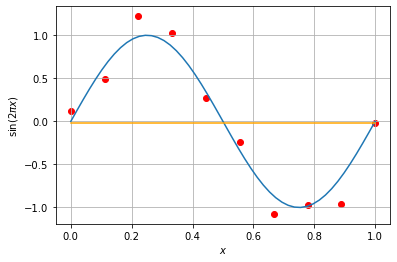

In [6]:
plt.figure()
plt.plot(np.arange(EPOCHS), train_loss)
plt.plot(np.arange(EPOCHS), val_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.grid()

model.eval()
y_pred = model(x_test_tensor)
y_pred = y_pred.cpu().detach().numpy().squeeze()
plt.figure()
plt.plot(x_val, y_val)
plt.plot(x_val, y_pred, color='orange')
plt.scatter(x_train, y_train, color='red')
plt.ylabel('$\sin(2 \pi x)$')
plt.xlabel('$x$')
plt.grid()

### 7. Para el transfer Learning, decidí usar el modelo visto en clases, para extrar los features, y despues usar algunos de los algortimos de SKLearn para clasificarlo.
---

<br>

A continuación  vuelvo a escribir todo el código base visto en clases para extraer los features.
El ejercició comienza a partir del Título KNN

In [7]:


if not os.path.exists("./data/hymenoptera_data"):

    url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
    root = './data/'

    download_and_extract_archive(url, root)
    print("Archivos descargados y extraidos con éxito")
    
else:
    print("La carpeta ya existe")

47287296it [00:10, 4575502.29it/s]                              


Extracting ./data/hymenoptera_data.zip to ./data/
Archivos descargados y extraidos con éxito


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader
from funciones_utiles import imshow_tensor

path = './data/hymenoptera_data/'

batch_size = 4
num_workers = 2

# transformaciones que se aplicarán sobre cada imagen:
#   1. el lado más chico de la imagen a 256 pixels manteniendo relación de aspecto (PIL -> PIL)
#   2. crop de la región central de 224x224 pixels (PIL -> PIL)
#   1. transformar la imagen PIL a un tensor de pytorch (PIL -> Tensor)
#   2. aplicar la normalización (estandarización) con la que fueron entrenados los modelos en torchvision  (Tensor -> Tensor)
transform = transforms.Compose([    
    transforms.Resize(256),    
    transforms.CenterCrop(224),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

torch.Size([4, 3, 224, 224])
tensor([0, 1, 0, 1])
['ants', 'bees', 'ants', 'bees']


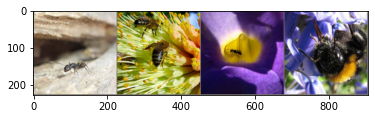

In [9]:
# dataset
data = ImageFolder(os.path.join(path, 'train'), transform)

# data loader
loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

image_batch, labels = next(iter(loader))
print(image_batch.size())
print(labels)
print([data.classes[lbl] for lbl in labels])
grid = make_grid(image_batch)
imshow_tensor(grid)

In [10]:
import torch
from torch import nn
from torchvision import models
from tqdm import tqdm_notebook as progressbar

class FeatureExtractor(nn.Module):
    def __init__(self):        
        super().__init__()
        # leer red pre-entrenada
        model = models.resnet18(pretrained=True)
        
        # congelamos los parámetros
        for p in model.parameters():
            p.requires_grad_(False)
            
        # armamos modelo secuencial que incluya todas las capas salvo la última (fc)
        layers = list(model.children())[:-1] # quitamos la última capa
        self.net = nn.Sequential(*layers) 
        
    def forward(self, x):        
        N = x.size(0)  # batch size
        x = self.net(x)
        return x.view(N, -1) # redimensionamos la salida para adaptarla a nuestro modelo

In [11]:
def features_and_labels(set_):
    if set_ not in ('train', 'val'):
        raise ValueError('not a valid data set')
        
    transform = transforms.Compose([    
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    data = ImageFolder(os.path.join(path, set_), transform)
    
    loader = DataLoader(data, batch_size=1, shuffle=False, num_workers=0)
    
    extractor = FeatureExtractor()
    extractor.eval()
    
    features, labels = [], []
    
    for img, lbl in progressbar(loader):
        feat = extractor(img)  
        features.append(feat)
        labels.append(lbl)


    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    return features, labels


In [12]:
train_features, train_labels = features_and_labels('train')
val_features, val_labels = features_and_labels('val')
print(train_features.size(), val_features.size())

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

torch.Size([244, 512]) torch.Size([153, 512])


In [13]:
x_train, y_train = train_features.cpu().numpy(), train_labels.cpu().numpy().reshape(-1, 1)
x_test, y_test = val_features.cpu().numpy(), val_labels.cpu().numpy().reshape(-1, 1)

# # para evitar recomputar los features cada vez, se pueden almacenar a disco 
# np.save("resnet18.npy", {'x_train': x_train, 'y_train': y_train, 'x_test': x_test, 'y_test': y_test}, allow_pickle=True)
# mydata = np.load("resnet18.npy", allow_pickle=True)
# x_train = mydata.item().get('x_train')
# y_train = mydata.item().get('y_train')
# x_test = mydata.item().get('x_test')
# y_test = mydata.item().get('y_test')

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# TODO:
# agrega tu código aquí para realizar una clasificación con modelos de sklearn

(244, 512) (244, 1)
(153, 512) (153, 1)


## KNN
---

El primer modelo que voy a aplicar va a ser KNN, ya que su funcionamiento es sencillo

#### Escalamos los datos

In [14]:
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
X_test = sc_X.transform(x_test)


#### Entrenamos el modelo

In [15]:

clf_sk = neighbors.KNeighborsClassifier(n_neighbors=5)
clf_sk.fit(x_train,y_train)
y_hat = clf_sk.predict(x_test)


#### Métricas

In [16]:
accuracy_escalado=accuracy_score(y_true=y_test, y_pred=y_hat)
print(f'Tasa de aciertos: {accuracy_escalado}')

Tasa de aciertos: 0.8300653594771242


In [17]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_hat, target_names=["Abejas","Hormigas"]))

              precision    recall  f1-score   support

      Abejas       0.96      0.66      0.78        70
    Hormigas       0.77      0.98      0.86        83

    accuracy                           0.83       153
   macro avg       0.86      0.82      0.82       153
weighted avg       0.86      0.83      0.82       153



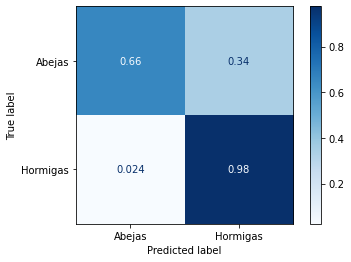

In [18]:
plot_confusion_matrix(clf_sk, x_test, y_test,
                      display_labels=["Abejas","Hormigas"],
                      cmap=plt.cm.Blues,
                      normalize='true')
plt.show()

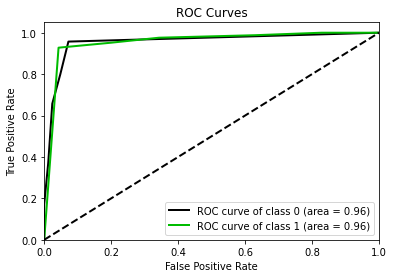

In [19]:
y_hat_probas = clf_sk.predict_proba(x_test)
skplt.metrics.plot_roc(y_test, y_hat_probas, plot_micro=False, plot_macro=False)
plt.show()

## XGBoost
---


Qué es XGBoost ?

- En el aprendizaje automático, los modelos conjuntos obtienen mejores resultados que los modelos individuales con una alta probabilidad. Un modelo de conjunto combina diferentes modelos de aprendizaje automático en uno solo. El bosque aleatorio es un conjunto muy popular que toma la media de muchos árboles de decisión mediante el ensamblaje. Bagging es la abreviatura de "bootstrap aggregation", lo que significa que las muestras se eligen con reemplazo (bootstrapping), y se combinan (agregan) tomando su media.
El "boosting" es una buena alternativa al "bagging". En lugar de agregar predicciones, los reforzadores convierten a los aprendices débiles en aprendices fuertes centrándose en los puntos en los que los modelos individuales (normalmente árboles de decisión) se equivocan. En el Gradient Boosting, los modelos individuales se entrenan sobre los residuos, la diferencia entre la predicción y los resultados reales. En lugar de agregar árboles, los árboles con refuerzo de gradiente aprenden de los errores durante cada ronda de refuerzo.
XGBoost es la abreviatura de "eXtreme Gradient Boosting". El término "eXtreme" se refiere a las mejoras de velocidad, como la computación en paralelo y el conocimiento de la caché, que hacen que XGBoost sea aproximadamente 10 veces más rápido que el Gradient Boosting tradicional. Además, XGBoost incluye un algoritmo único de búsqueda de divisiones para optimizar los árboles, junto con una regularización incorporada que reduce el sobreajuste. En general, XGBoost es una versión más rápida y precisa del Gradient Boosting

<br>


XGBoost no requiere scalar los datos, ya que está basado en sus origenes en un árbol de decisión

Decidí implementar este algoritmo, para combinar el poder de las redes neuronales con uno de los algortimos más poderos que es XGBoost, y ver que resultados obtengo

[Fuente](https://towardsdatascience.com/getting-started-with-xgboost-in-scikit-learn-f69f5f470a97)



In [20]:
x_train, y_train = train_features.cpu().numpy(), train_labels.cpu().numpy().reshape(-1, 1)
x_test, y_test = val_features.cpu().numpy(), val_labels.cpu().numpy().reshape(-1, 1)

In [21]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",use_label_encoder=False )
xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)

accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'Tasa de aciertos: {accuracy}')

[20:39:11] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Tasa de aciertos: 0.9411764705882353


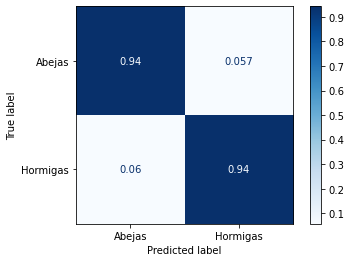

In [22]:
plot_confusion_matrix(xgb_model, x_test, y_test,
                      display_labels=["Abejas","Hormigas"],
                      cmap=plt.cm.Blues,
                      normalize='true')
plt.show()

#### Búsqueda en grilla
---

Decidí aplicar una búsqueda en grilla para ver si podemos aumentar aún más la calidad de nuestro modelo


In [23]:
x_train, y_train = train_features.cpu().numpy(), train_labels.cpu().numpy().reshape(-1, 1)
x_test, y_test = val_features.cpu().numpy(), val_labels.cpu().numpy().reshape(-1, 1)

In [24]:
xgb_model = xgb.XGBClassifier( objective="binary:logistic", eval_metric='mlogloss')

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4),
    'verbosity': [0],
    'n_jobs': [-1],
    'eval_metric':['mlogloss'],
    'use_label_encoder':[False]
}

search = RandomizedSearchCV(xgb_model, param_distributions=params,  n_iter=35, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(x_train, y_train)



Fitting 3 folds for each of 35 candidates, totalling 105 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='mlogloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A215EB9508>,
                                        'max_dep

In [25]:
search.best_params_

{'colsample_bytree': 0.8233534396517617,
 'eval_metric': 'mlogloss',
 'gamma': 0.4413172225884209,
 'learning_rate': 0.2378124044384247,
 'max_depth': 2,
 'n_estimators': 105,
 'n_jobs': -1,
 'subsample': 0.6257760924741134,
 'use_label_encoder': False,
 'verbosity': 0}

Débido a que nuestra búsqueda es aleatoria, los resultados que se obtienen varian con cada ejecución, pero, al ejecutar varias pruebas, podremos ver que la tasa de precisión ronda entre los 92% a 95%, lo cual es un muy buen indicador de la calidad del XGBoost

In [26]:
xgb_model = xgb.XGBClassifier(colsample_bytree=0.8233534396517617, eval_metric='mlogloss', gamma= 0.44131722258842093, learning_rate= 0.2378124044384247, max_depth= 2, n_estimators= 105, n_jobs= -1, subsample= 0.6257760924741134, 
use_label_encoder= False, verbosity= 0)
xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)

accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'Tasa de aciertos: {accuracy}')

Tasa de aciertos: 0.9411764705882353


<AxesSubplot:>

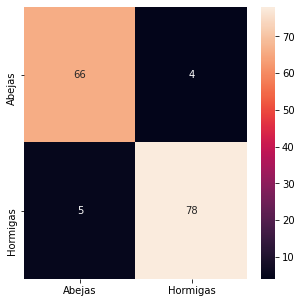

In [27]:


columas=["Abejas","Hormigas"]
cm=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = columas,
                  columns = columas)
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)

In [28]:
print(metrics.classification_report(y_test, y_pred, target_names=["Abejas","Hormigas"]))

              precision    recall  f1-score   support

      Abejas       0.93      0.94      0.94        70
    Hormigas       0.95      0.94      0.95        83

    accuracy                           0.94       153
   macro avg       0.94      0.94      0.94       153
weighted avg       0.94      0.94      0.94       153



### Conclusión:
Podemos decir, que usar las redes neuronales para extraer los features de un dataset, para despues aplicarlos los "algoritmos clásicos" de machine learning, es una buena combinación, ya que conmuy poco esfuerzo, conseguimos excelentes resultados.
<br>
Si comparamos el KNN, que es un modelo sencillo, tuvimos una precisión del 80% (por tomar el accuracy como punto de comparación), mientras que con XGBoost obtuvimos un poco más del 90%.
<br>
Tambien de esta forma, desde mi punto de vista, ganamos mayor explicabilidad para nuestro modelo, sino, muchas veces las redes neuronales son vistas como cajas negras, donde entra algo, la computadora se encarga de realizar la extraccion de carácteristicas y nos devuelve un numero, y esto se vuelve más confuso mientras más compleja es la arquitectura de la red neuronal, cosa que no sucede con los algoritmos clásicos (obviamente al aumentar la dimensión es más dificil de explicar).